In [1]:
from projet_etu import *
from mltools import *
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [2]:
def load_usps(fn):
    with open(fn,"r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp=np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

In [3]:
def get_usps(l,datax,datay):
    if type(l)!=list:
        resx = datax[datay==l,:]
        resy = datay[datay==l]
        return resx,resy
    tmp =   list(zip(*[get_usps(i,datax,datay) for i in l]))
    tmpx,tmpy = np.vstack(tmp[0]),np.hstack(tmp[1])
    return tmpx,tmpy

In [4]:
def show_usps(images, random_indices ,n_images = 10):

    fig, axs = plt.subplots(1, n_images, figsize=(16, 4))
    for i, index in enumerate(random_indices):
        axs[i].imshow(images[index].reshape((16, 16)), cmap='gray')
        axs[i].axis('off')
    plt.show()

In [5]:
def one_hot(y,nb_classes):
    """
    Permet de transformer un vecteur d'indices y de classes en one-hot
    """
    onehot = np.zeros((y.size, nb_classes))
    onehot[np.arange(y.size), y] = 1
    return onehot

In [6]:
def normalize(datax, testx):
    min_value = np.min(np.concatenate((datax,testx)))
    max_value = np.max(np.concatenate((datax,testx)))

    datax_norm = (datax - min_value) / (max_value - min_value)
    testx_norm = (testx - min_value) / (max_value - min_value)

    return datax_norm, testx_norm

In [7]:
def generate_data(classes):
    """
    classes : liste des classes
    """
    uspsdatatrain = "./data/USPS_train.txt"
    uspsdatatest = "./data/USPS_test.txt"
    
    alltrainx,alltrainy = load_usps(uspsdatatrain)
    alltestx,alltesty = load_usps(uspsdatatest)
    
    datax,datay = get_usps(classes,alltrainx,alltrainy)
    testx,testy = get_usps(classes,alltestx,alltesty)

    datax, testx = normalize(datax, testx)

    datay = one_hot(datay, len(classes))
    testy = one_hot(testy, len(classes))
    
    datax = np.expand_dims(datax, axis=2)
    testx = np.expand_dims(testx, axis=2)
    
    return datax, testx, datay, testy

In [8]:
def noisy_data(data, type, proportion):
    """
    Ajoute du bruit à un jeu de données.
    data : numpy array, les données à bruitées
    type : str, le type de bruit ('gaussian', 'salt_and_pepper', 'poisson')
    p : float, la proportion de pixels bruités
    
    Retourne les données bruitées
    """
    noisy_data = np.copy(data)
    if type == 'gaussian':
        # Ajouter du bruit gaussien
        mean = 0
        variance = 0.1
        sigma = variance ** 0.5
        for i in range(noisy_data.shape[0]):
            noisy_data[i] += proportion * np.random.normal(mean, sigma, noisy_data[i].shape)
            
    elif type == 'salt_and_pepper':
        # Ajouter du bruit de sel et poivre
        for i in range(noisy_data.shape[0]):
            mask = np.random.rand(*noisy_data[i].shape) < proportion
            noisy_data[i][mask] = 0 if random.random() < 0.5 else 1
            
    elif type == 'poisson':
        # Ajouter du bruit de poisson
        for i in range(noisy_data.shape[0]):
            noisy_data[i] += np.random.poisson(lam=0.1, size=noisy_data[i].shape)
            
    return noisy_data

In [9]:
def plot_loss(iter,liste_loss):
    """
    Trace le graphe de l'évolution de la fonction de coût en fonction des itérations de la descente de gradient.

    iter: Le nombre d'itérations de la descente de gradient.
    liste_loss: La liste des valeurs de la fonction de coût à chaque itération.
    """
    plt.figure()
    plt.plot(np.arange(iter),liste_loss)
    plt.title("Loss")
    plt.xlabel("Iterations")
    plt.ylabel("loss")
    plt.show()

In [10]:
def predict(opt, testx):
    res_forward = [ opt._net._modules[0].forward(testx) ]

    for j in range(1, len(opt._net._modules)):
        res_forward.append( opt._net._modules[j].forward( res_forward[-1] ) )
    
    yhat = np.argmax(res_forward[-1], axis=1)

    onehot = np.zeros((yhat.size, len(np.unique(yhat))))
    onehot[ np.arange(yhat.size), yhat ] = 1
    yhat = onehot

    return yhat

In [11]:
def show_predict(img, index, yhat):
    fig, ax = plt.subplots(figsize=(3,3))
    ax.imshow(img[index].reshape((16, 16)), cmap='gray')
    ax.axis('off')
    plt.title("Prediction : " + str(yhat))
    plt.show()

# Max Pooling

In [12]:
# Création données et constantes : 
classes = [i for i in range(10)]
datax,testx, datay, testy = generate_data(classes)

iteration = 200
gradient_step = 1e-4
size_batch = 100

In [13]:
print(datax.shape)

(7291, 256, 1)


In [14]:
# Module linéaire et Loss
loss = CElogSMLoss()

conv = Conv1D(3, 1, 32, 1)
maxpool = MaxPool1D(2, 2)
flatten = Flatten()
linear1 = Linear(4064, 100)
relu = ReLU()
linear2 = Linear(100, 10)


In [15]:
seq = Sequential([conv,maxpool,
                  flatten,linear1,
                  relu, linear2])

In [16]:
opt = Optim(seq, loss, eps=gradient_step)

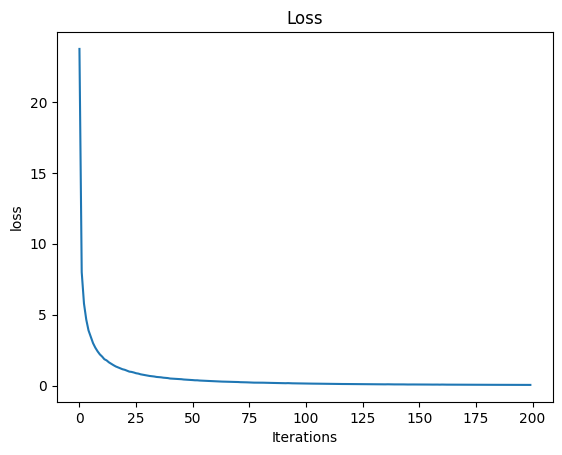

In [17]:
list_loss = opt.SGD(datax,datay,size_batch,iteration)
plot_loss(iteration,list_loss)

In [18]:
yhat = predict(opt, testx)
yhat_classes = np.argmax(yhat, axis=1) 
testy_classes = np.argmax(testy, axis=1)
print("Taux de bonnes classifications : ", np.mean(yhat_classes == testy_classes))

Taux de bonnes classifications :  0.833582461385152


## Matrice de confusion

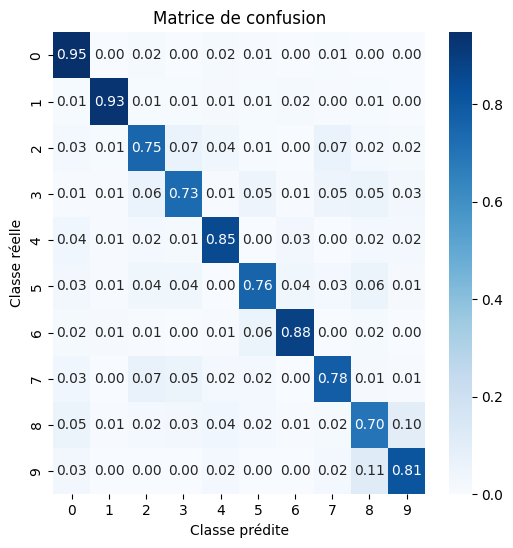

In [21]:
cm = confusion_matrix(testy_classes, yhat_classes)

plt.figure(figsize=(6,6))
sns.heatmap(cm/np.sum(cm, axis=1)[:, np.newaxis], annot=True, cmap="Blues", fmt=".2f")
plt.title("Matrice de confusion")
plt.ylabel('Classe réelle')
plt.xlabel('Classe prédite')
plt.show()

## Show Prediction

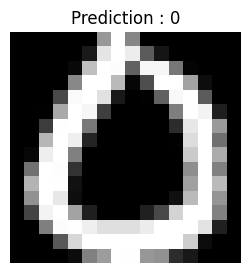

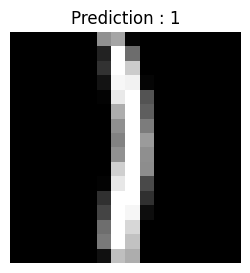

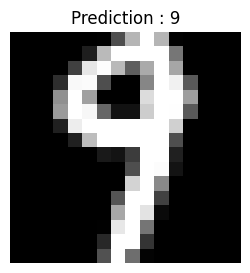

In [27]:
show_predict(testx, 0, yhat_classes[0])
show_predict(testx, 400, yhat_classes[400])
show_predict(testx, 2000, yhat_classes[2000])

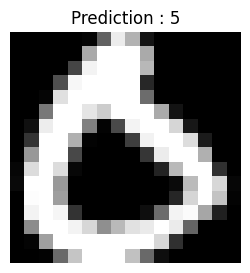

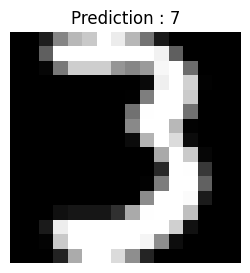

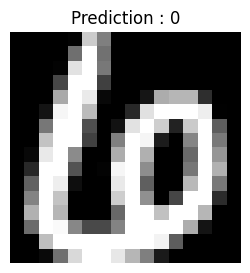

In [28]:
wrong_indices = np.where(yhat != testy)[0] # liste des indices des mauvaises prédictions
show_predict(testx, wrong_indices[0], yhat_classes[wrong_indices[0]])
show_predict(testx, wrong_indices[200], yhat_classes[wrong_indices[200]])
show_predict(testx, wrong_indices[400], yhat_classes[wrong_indices[400]])


# Average Pooling

In [12]:
# Création données et constantes : 
classes = [i for i in range(10)]
datax,testx, datay, testy = generate_data(classes)

iteration = 200
gradient_step = 1e-4
size_batch = 100

print(datax.shape)

# Module linéaire et Loss
loss = CElogSMLoss()

conv = Conv1D(3, 1, 32, 1)
avgpool = AvgPool1D(2, 2)
flatten = Flatten()
linear1 = Linear(4064, 100)
relu = ReLU()
linear2 = Linear(100, 10)


seq = Sequential([conv,avgpool,
                  flatten,linear1,
                  relu, linear2])

opt = Optim(seq, loss, eps=gradient_step)



(7291, 256, 1)


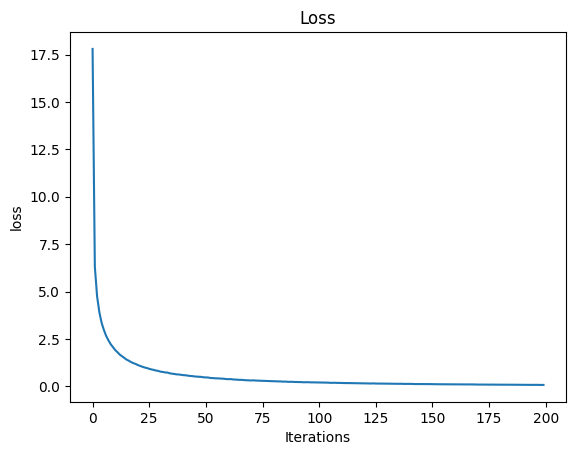

In [13]:
list_loss = opt.SGD(datax,datay,size_batch,iteration)
plot_loss(iteration,list_loss)

In [14]:
yhat = predict(opt, testx)
yhat_classes = np.argmax(yhat, axis=1) 
testy_classes = np.argmax(testy, axis=1)
print("Taux de bonnes classifications : ", np.mean(yhat_classes == testy_classes))

Taux de bonnes classifications :  0.8380667663178873


## Matrice de confusion

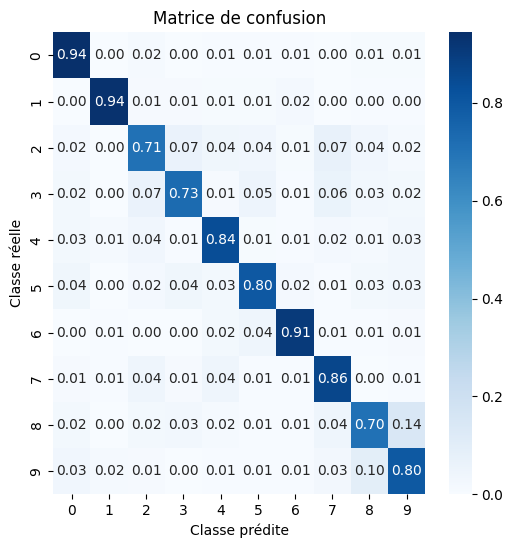

In [15]:
cm = confusion_matrix(testy_classes, yhat_classes)

plt.figure(figsize=(6,6))
sns.heatmap(cm/np.sum(cm, axis=1)[:, np.newaxis], annot=True, cmap="Blues", fmt=".2f")
plt.title("Matrice de confusion")
plt.ylabel('Classe réelle')
plt.xlabel('Classe prédite')
plt.show()

## Show Prediction

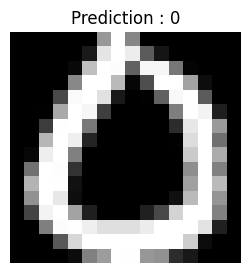

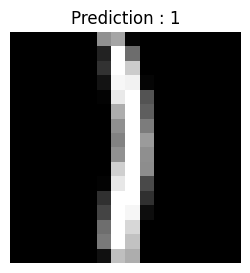

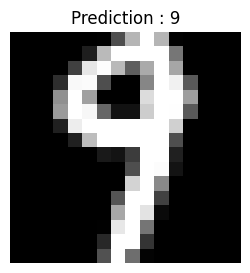

In [16]:
show_predict(testx, 0, yhat_classes[0])
show_predict(testx, 400, yhat_classes[400])
show_predict(testx, 2000, yhat_classes[2000])

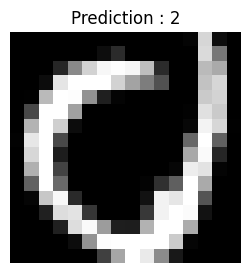

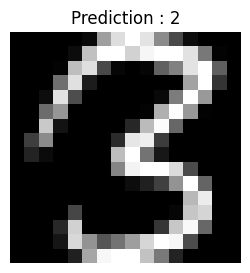

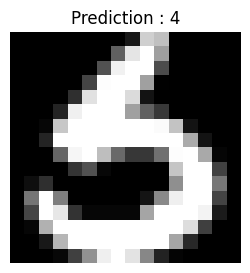

In [17]:
wrong_indices = np.where(yhat != testy)[0] # liste des indices des mauvaises prédictions
show_predict(testx, wrong_indices[0], yhat_classes[wrong_indices[0]])
show_predict(testx, wrong_indices[200], yhat_classes[wrong_indices[200]])
show_predict(testx, wrong_indices[400], yhat_classes[wrong_indices[400]])